Bag of Binary Words

In [2]:
import glob
import random
random.seed(123123)

In [3]:
import cv2
import numpy as np


In [4]:
import dbow


In [17]:
# Load Images
images_path = glob.glob('./images/*.png')
images = []
for image_path in images_path:
    images.append(cv2.imread(image_path))


In [18]:
# Create Vocabulary
n_clusters = 10
depth = 2
vocabulary = dbow.Vocabulary(images, n_clusters, depth)


In [7]:
orb = cv2.ORB_create()


In [8]:
# Convert images to Bag of Binary Words and calculate scores between them
bows = []
for image in images:
    kps, descs = orb.detectAndCompute(image, None)
    descs = [dbow.ORB.from_cv_descriptor(desc) for desc in descs]
    bows.append(vocabulary.descs_to_bow(descs))

for i in range(len(bows)):
    for j in range(len(bows)):
        print(f'Similarity between Image {i} and Image {j} = {bows[i].score(bows[j])}')
    print('\n')


In [19]:
# Create a database
db = dbow.Database(vocabulary)
for image in images:
    kps, descs = orb.detectAndCompute(image, None)
    descs = [dbow.ORB.from_cv_descriptor(desc) for desc in descs]
    db.add(descs)


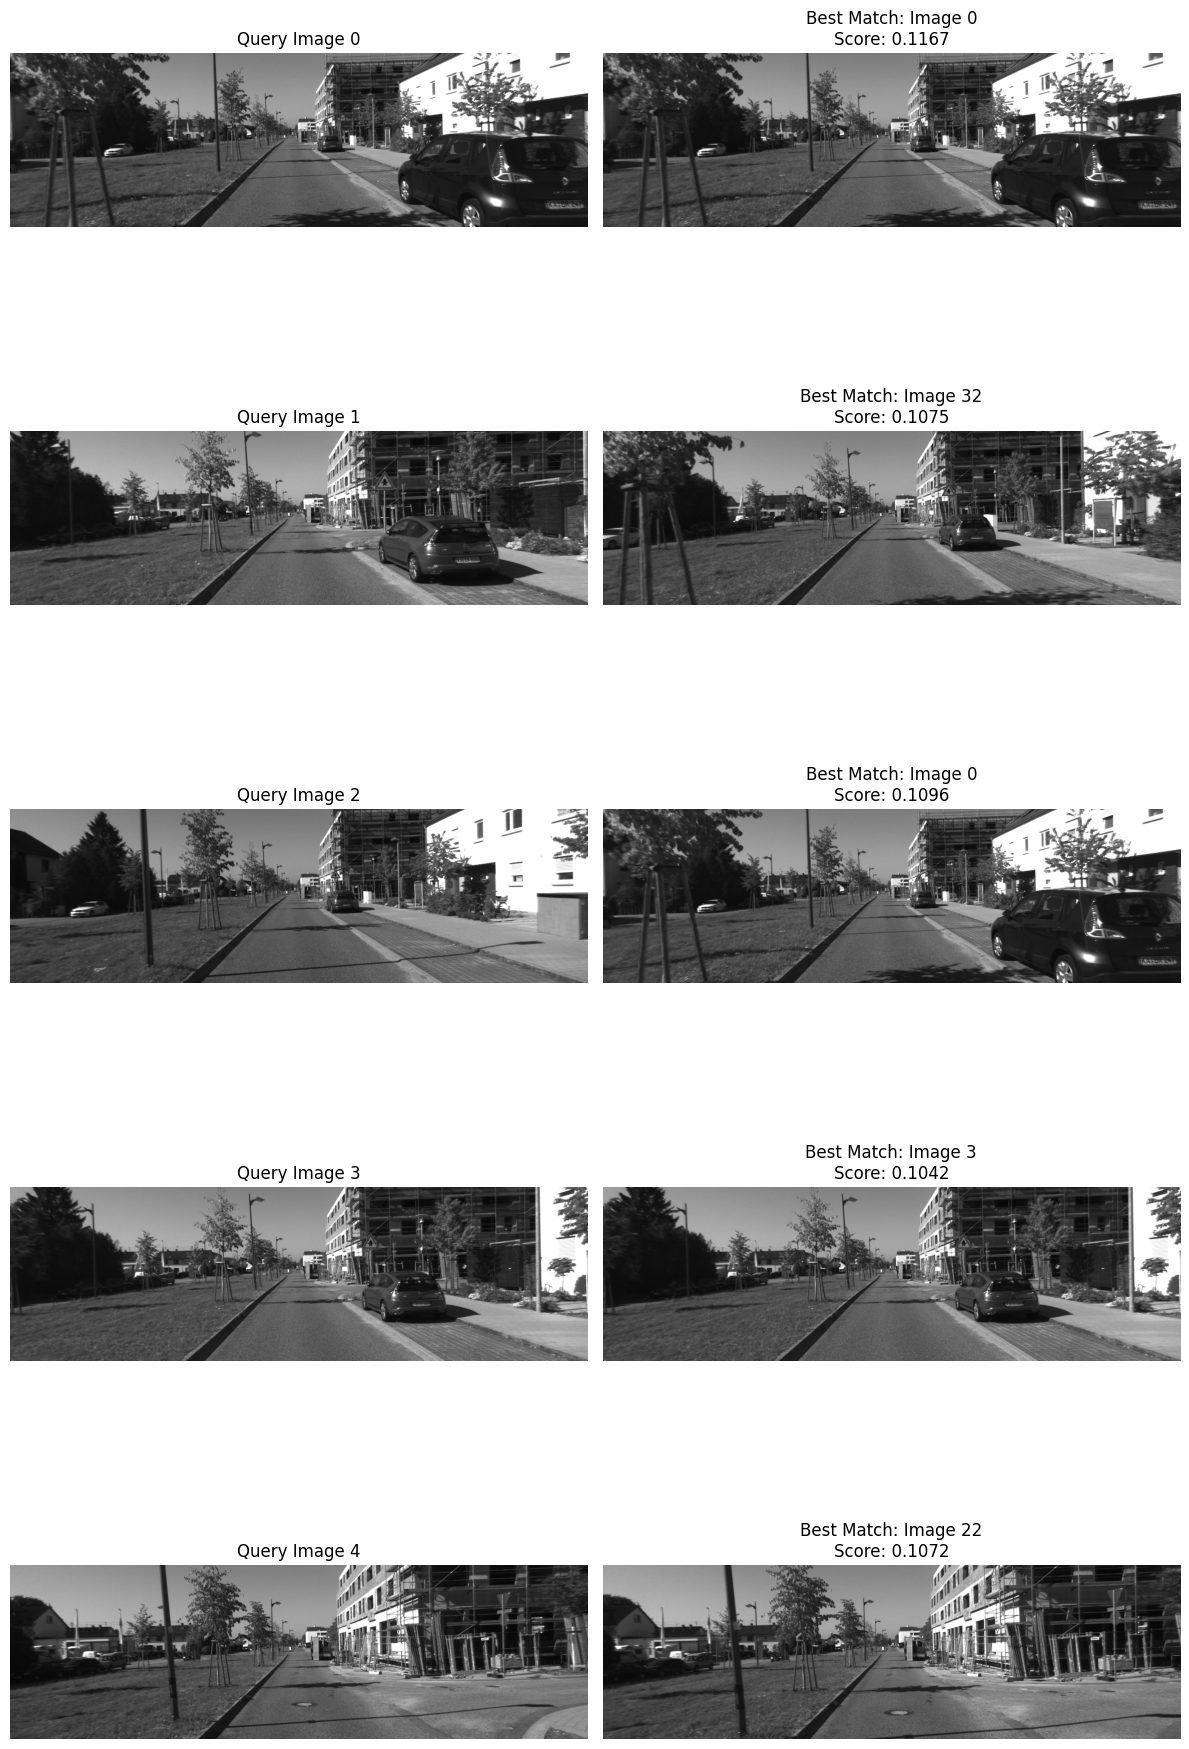

Matched image pairs displayed (first 5 queries)!


In [ ]:
# Query the database and visualize results
import matplotlib.pyplot as plt

if len(images) > 0:
    # Visualize first 5 query results
    n_display = min(5, len(images))
    fig, axes = plt.subplots(n_display, 2, figsize=(12, 4 * n_display))
    if n_display == 1:
        axes = axes.reshape(1, -1)

    for idx in range(n_display):
        image = images[idx]
        kps, descs = orb.detectAndCompute(image, None)
        descs = [dbow.ORB.from_cv_descriptor(desc) for desc in descs]
        scores = db.query(descs)
        best_idx = np.argmax(scores)
        
        # Show query image
        axes[idx, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[idx, 0].set_title(f'Query Image {idx}')
        axes[idx, 0].axis('off')
        
        # Show best match
        best_image = images[best_idx]
        axes[idx, 1].imshow(cv2.cvtColor(best_image, cv2.COLOR_BGR2RGB))
        axes[idx, 1].set_title(f'Best Match: Image {best_idx}\nScore: {scores[best_idx]:.4f}')
        axes[idx, 1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Matched image pairs displayed (first {n_display} queries)!")
else:
    print("No images loaded yet. Please load images first.")

In [11]:
# Saving and Loading the vocabulary
vocabulary.save('vocabulary.pickle')
loaded_vocabulary = vocabulary.load('vocabulary.pickle')
for image in images:
    kps, descs = orb.detectAndCompute(image, None)
    descs = [dbow.ORB.from_cv_descriptor(desc) for desc in descs]
    loaded_vocabulary.descs_to_bow(descs)
    

In [12]:
# Saving and Loading the database
db.save('database.pickle')
loaded_db = db.load('database.pickle')
for image in images:
    kps, descs = orb.detectAndCompute(image, None)
    descs = [dbow.ORB.from_cv_descriptor(desc) for desc in descs]
    scores = loaded_db.query(descs)
    print(loaded_db[np.argmax(scores)], np.argmax(scores))

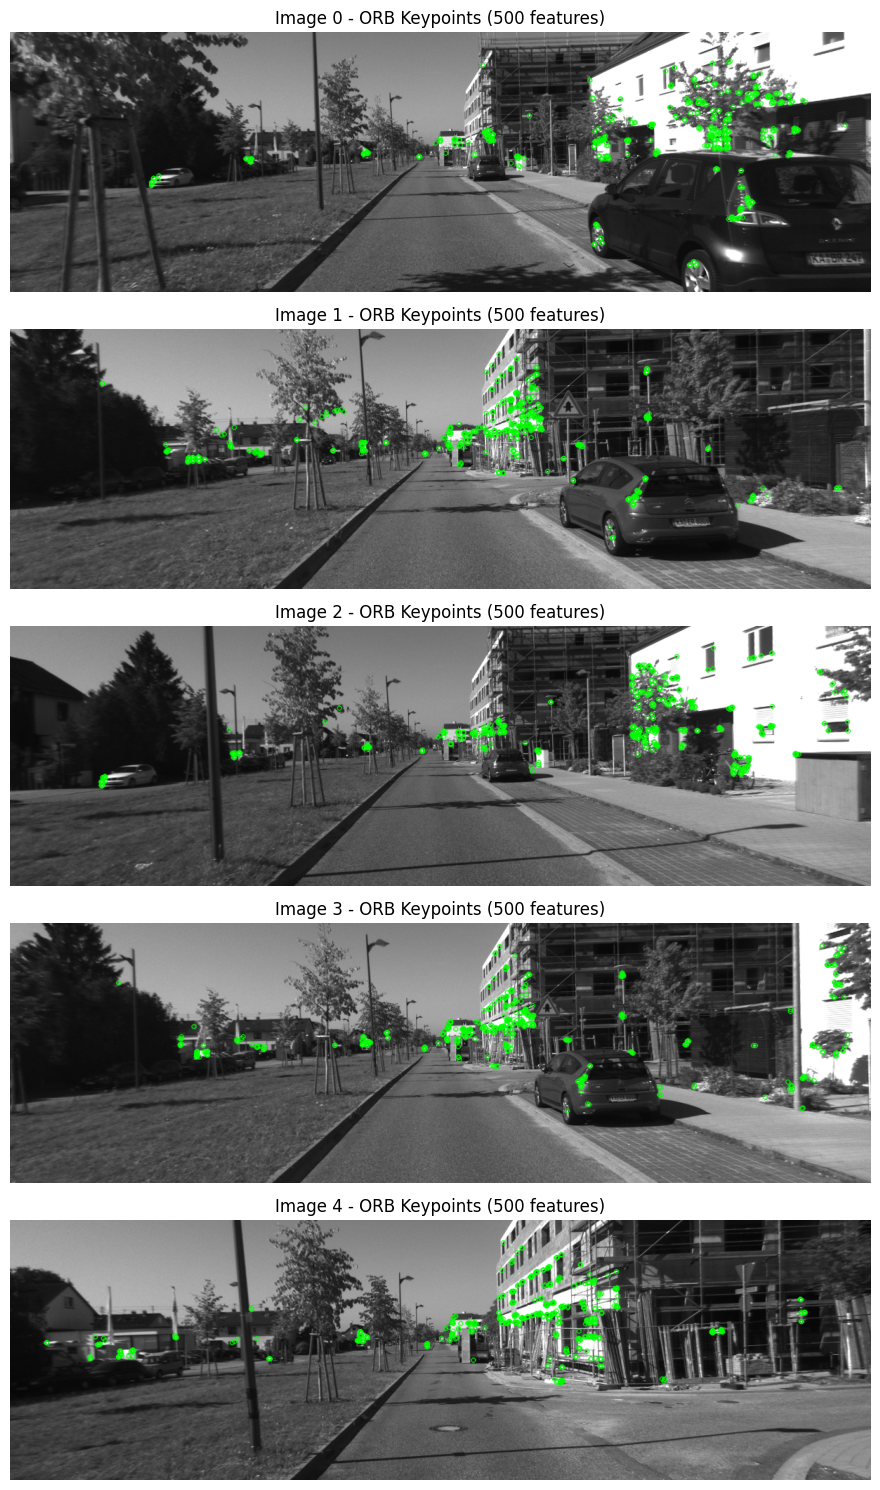

ORB keypoints visualized for first 5 images


In [21]:
# Visualize ORB keypoints on first few images
if len(images) > 0:
    n_display = min(5, len(images))
    fig, axes = plt.subplots(n_display, 1, figsize=(12, 3 * n_display))
    if n_display == 1:
        axes = [axes]

    for idx in range(n_display):
        img_with_kps = images[idx].copy()
        kps, descs = orb.detectAndCompute(images[idx], None)
        
        # Draw keypoints
        img_with_kps = cv2.drawKeypoints(img_with_kps, kps, None, color=(0, 255, 0), flags=0)
        
        axes[idx].imshow(cv2.cvtColor(img_with_kps, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f'Image {idx} - ORB Keypoints ({len(kps)} features)')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"ORB keypoints visualized for first {n_display} images")
else:
    print("No images loaded yet. Please load images first.")

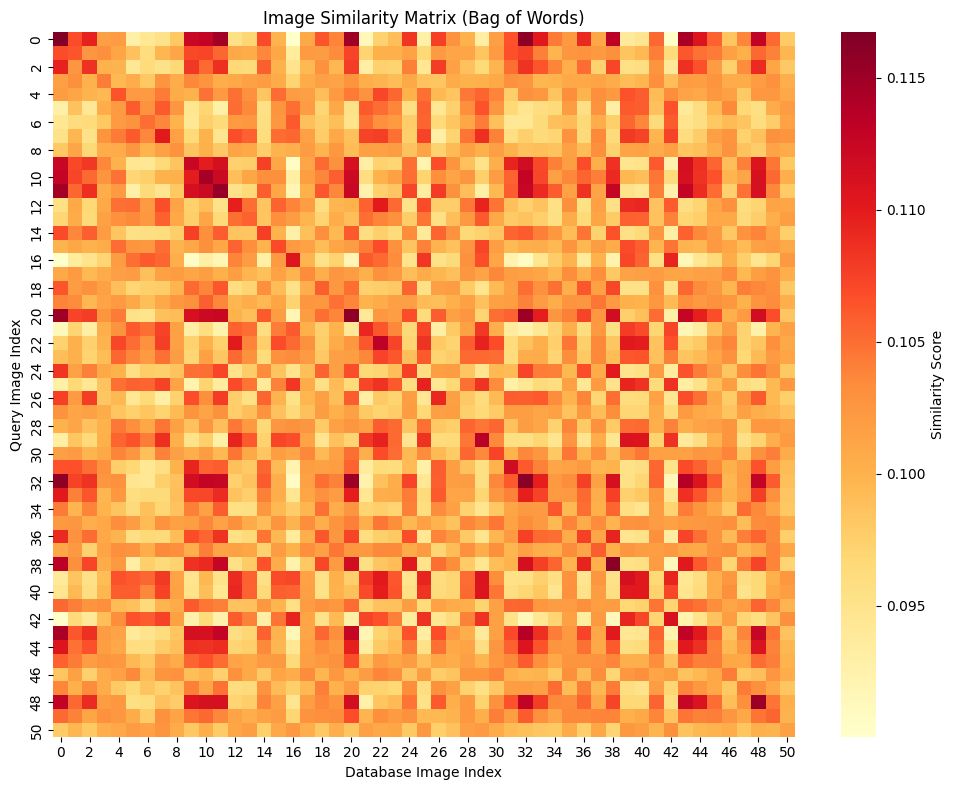

Similarity matrix heatmap displayed!


In [22]:
# Visualize similarity matrix as heatmap
import seaborn as sns

if len(images) > 0:
    # Compute similarity matrix
    similarity_matrix = np.zeros((len(images), len(images)))
    for i, img_i in enumerate(images):
        kps_i, descs_i = orb.detectAndCompute(img_i, None)
        descs_i = [dbow.ORB.from_cv_descriptor(desc) for desc in descs_i]
        scores = db.query(descs_i)
        similarity_matrix[i] = scores

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Similarity Score'})
    plt.xlabel('Database Image Index')
    plt.ylabel('Query Image Index')
    plt.title('Image Similarity Matrix (Bag of Words)')
    plt.tight_layout()
    plt.show()

    print("Similarity matrix heatmap displayed!")
else:
    print("No images loaded yet. Please load images first.")

In [ ]:
# SLAM Trajectory Visualization

#Visualize Ground Truth (GT) and Estimated trajectories from Visual Odometry

In [23]:
# Load KITTI poses (Ground Truth)
import os
import sys

# Load GT poses from KITTI sequence
data_dir = './KITTI_sequence_1'
gt_poses = []
poses_file = os.path.join(data_dir, 'poses.txt')

with open(poses_file, 'r') as f:
    for line in f.readlines():
        T = np.fromstring(line, dtype=np.float64, sep=' ')
        T = T.reshape(3, 4)
        T = np.vstack((T, [0, 0, 0, 1]))
        gt_poses.append(T)

# Extract X, Z coordinates (camera trajectory in XZ plane)
gt_path = np.array([[pose[0, 3], pose[2, 3]] for pose in gt_poses])

print(f"Loaded {len(gt_poses)} GT poses")
print(f"First pose:\n{gt_poses[0]}")
print(f"Trajectory shape: {gt_path.shape}")

Loaded 51 GT poses
First pose:
[[ 1.000000e+00  1.197625e-11  1.704638e-10  0.000000e+00]
 [ 1.197625e-11  1.000000e+00  3.562503e-10 -1.110223e-16]
 [ 1.704638e-10  3.562503e-10  1.000000e+00  2.220446e-16]
 [ 0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00]]
Trajectory shape: (51, 2)


In [24]:
# Simulate estimated trajectory (for demo - in practice this comes from VO/SLAM)
# We'll add small random noise to GT to simulate estimation error
np.random.seed(42)
estimated_path = gt_path.copy()
estimated_path += np.random.randn(*gt_path.shape) * 0.5  # Add noise to simulate estimation error

print(f"Estimated trajectory shape: {estimated_path.shape}")
print(f"Mean error: {np.mean(np.linalg.norm(gt_path - estimated_path, axis=1)):.4f} meters")

Estimated trajectory shape: (51, 2)
Mean error: 0.5817 meters


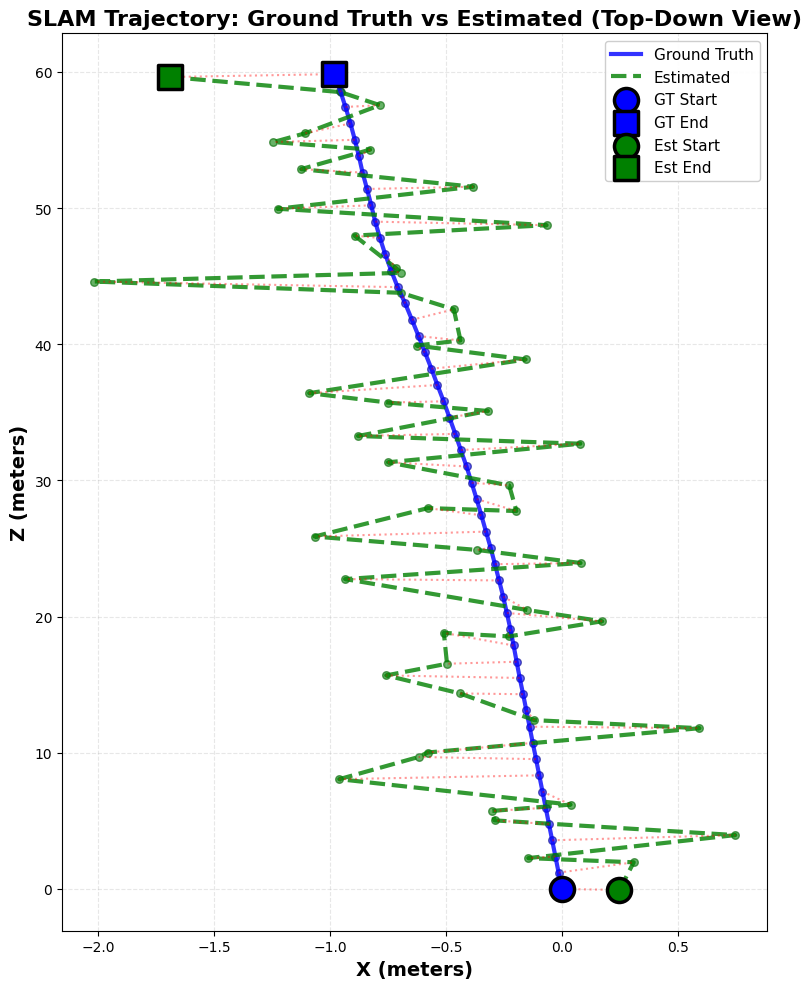

2D trajectory visualization displayed!


In [38]:
# Visualize 2D trajectory (XZ plane top-down view)
fig, ax = plt.subplots(figsize=(18, 10))

# Plot GT path
ax.plot(gt_path[:, 0], gt_path[:, 1], 'b-', linewidth=3, label='Ground Truth', alpha=0.8)
ax.scatter(gt_path[:, 0], gt_path[:, 1], c='blue', s=30, alpha=0.6, edgecolors='darkblue', linewidth=1)

# Plot estimated path
ax.plot(estimated_path[:, 0], estimated_path[:, 1], 'g--', linewidth=3, label='Estimated', alpha=0.8)
ax.scatter(estimated_path[:, 0], estimated_path[:, 1], c='green', s=30, alpha=0.6, edgecolors='darkgreen', linewidth=1)

# Draw dotted lines between GT and estimated for every point
for i in range(len(gt_path)):
    ax.plot([gt_path[i, 0], estimated_path[i, 0]], 
            [gt_path[i, 1], estimated_path[i, 1]], 
            'r:', linewidth=1.5, alpha=0.4)

# Mark start and end
ax.scatter(gt_path[0, 0], gt_path[0, 1], c='blue', s=300, marker='o', edgecolors='black', linewidth=2.5, label='GT Start', zorder=5)
ax.scatter(gt_path[-1, 0], gt_path[-1, 1], c='blue', s=300, marker='s', edgecolors='black', linewidth=2.5, label='GT End', zorder=5)

ax.scatter(estimated_path[0, 0], estimated_path[0, 1], c='green', s=300, marker='o', edgecolors='black', linewidth=2.5, label='Est Start', zorder=5)
ax.scatter(estimated_path[-1, 0], estimated_path[-1, 1], c='green', s=300, marker='s', edgecolors='black', linewidth=2.5, label='Est End', zorder=5)

ax.set_xlabel('X (meters)', fontsize=14, fontweight='bold')
ax.set_ylabel('Z (meters)', fontsize=14, fontweight='bold')
ax.set_title('SLAM Trajectory: Ground Truth vs Estimated (Top-Down View)', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3, linestyle='--')

# Balanced aspect ratio - show trajectory naturally with error lines visible
x_range = gt_path[:, 0].max() - gt_path[:, 0].min()
y_range = gt_path[:, 1].max() - gt_path[:, 1].min()
ax.set_aspect(y_range / 1000*x_range)  # Natural aspect ratio

plt.tight_layout()
plt.show()

print("2D trajectory visualization displayed!")

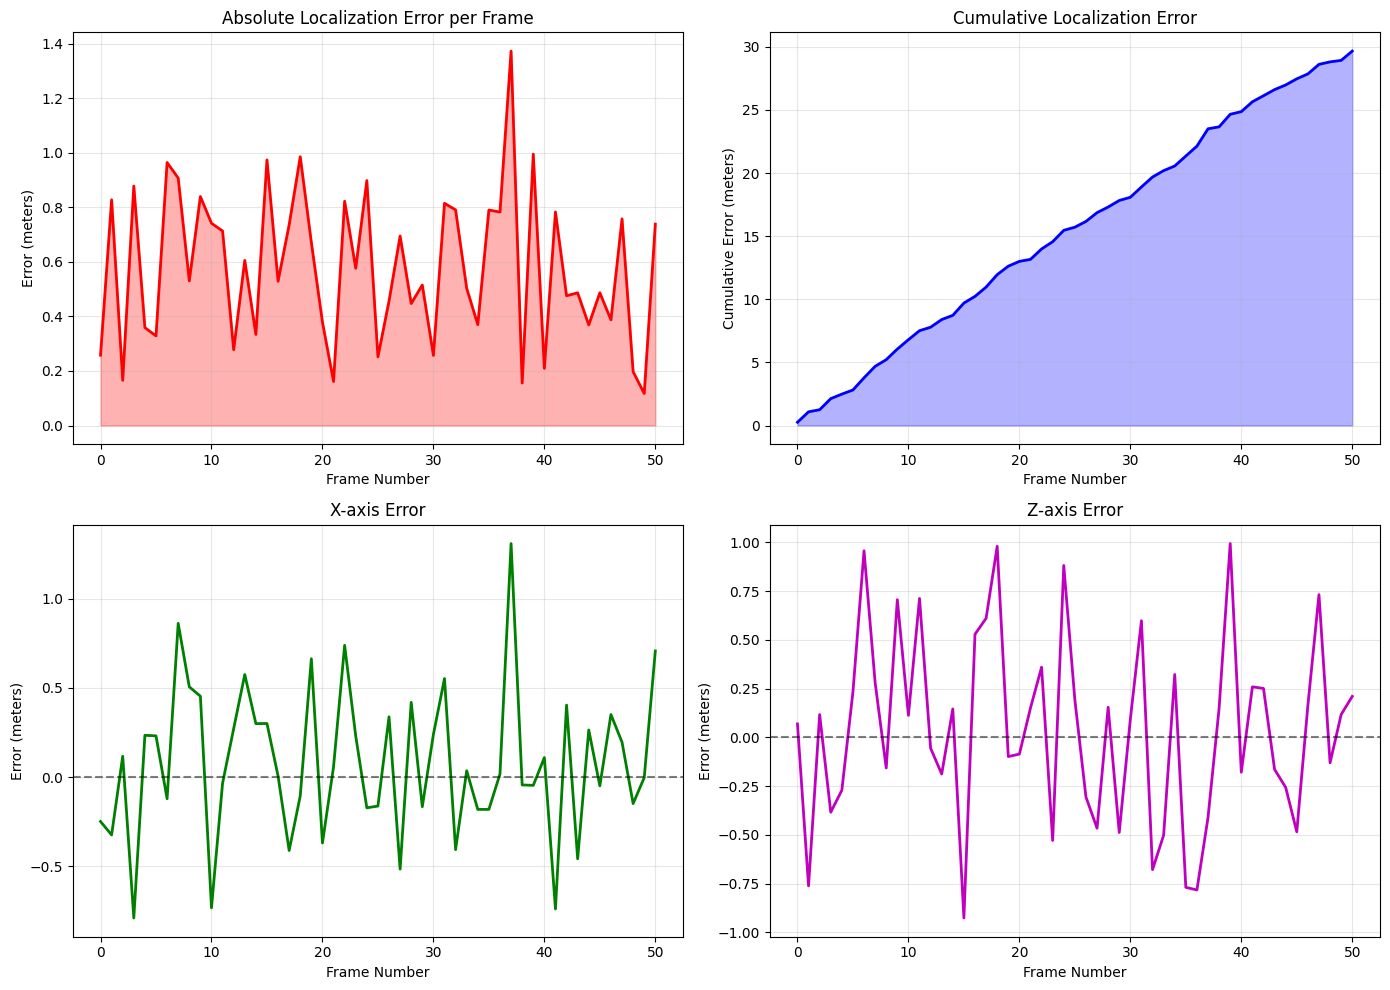

Error Statistics:
  Mean Error: 0.5817 meters
  Std Dev: 0.2791 meters
  Min Error: 0.1173 meters
  Max Error: 1.3728 meters
  Final Error: 0.7383 meters
  Total Cumulative Error: 29.6654 meters


In [26]:
# Calculate and visualize errors
errors = np.linalg.norm(gt_path - estimated_path, axis=1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Absolute error per frame
axes[0, 0].plot(errors, 'r-', linewidth=2)
axes[0, 0].fill_between(range(len(errors)), errors, alpha=0.3, color='red')
axes[0, 0].set_xlabel('Frame Number')
axes[0, 0].set_ylabel('Error (meters)')
axes[0, 0].set_title('Absolute Localization Error per Frame')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Cumulative error
cumulative_error = np.cumsum(errors)
axes[0, 1].plot(cumulative_error, 'b-', linewidth=2)
axes[0, 1].fill_between(range(len(cumulative_error)), cumulative_error, alpha=0.3, color='blue')
axes[0, 1].set_xlabel('Frame Number')
axes[0, 1].set_ylabel('Cumulative Error (meters)')
axes[0, 1].set_title('Cumulative Localization Error')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: X error
x_error = gt_path[:, 0] - estimated_path[:, 0]
axes[1, 0].plot(x_error, 'g-', linewidth=2, label='X Error')
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Frame Number')
axes[1, 0].set_ylabel('Error (meters)')
axes[1, 0].set_title('X-axis Error')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Z error
z_error = gt_path[:, 1] - estimated_path[:, 1]
axes[1, 1].plot(z_error, 'm-', linewidth=2, label='Z Error')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Frame Number')
axes[1, 1].set_ylabel('Error (meters)')
axes[1, 1].set_title('Z-axis Error')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Error Statistics:")
print(f"  Mean Error: {np.mean(errors):.4f} meters")
print(f"  Std Dev: {np.std(errors):.4f} meters")
print(f"  Min Error: {np.min(errors):.4f} meters")
print(f"  Max Error: {np.max(errors):.4f} meters")
print(f"  Final Error: {errors[-1]:.4f} meters")
print(f"  Total Cumulative Error: {cumulative_error[-1]:.4f} meters")

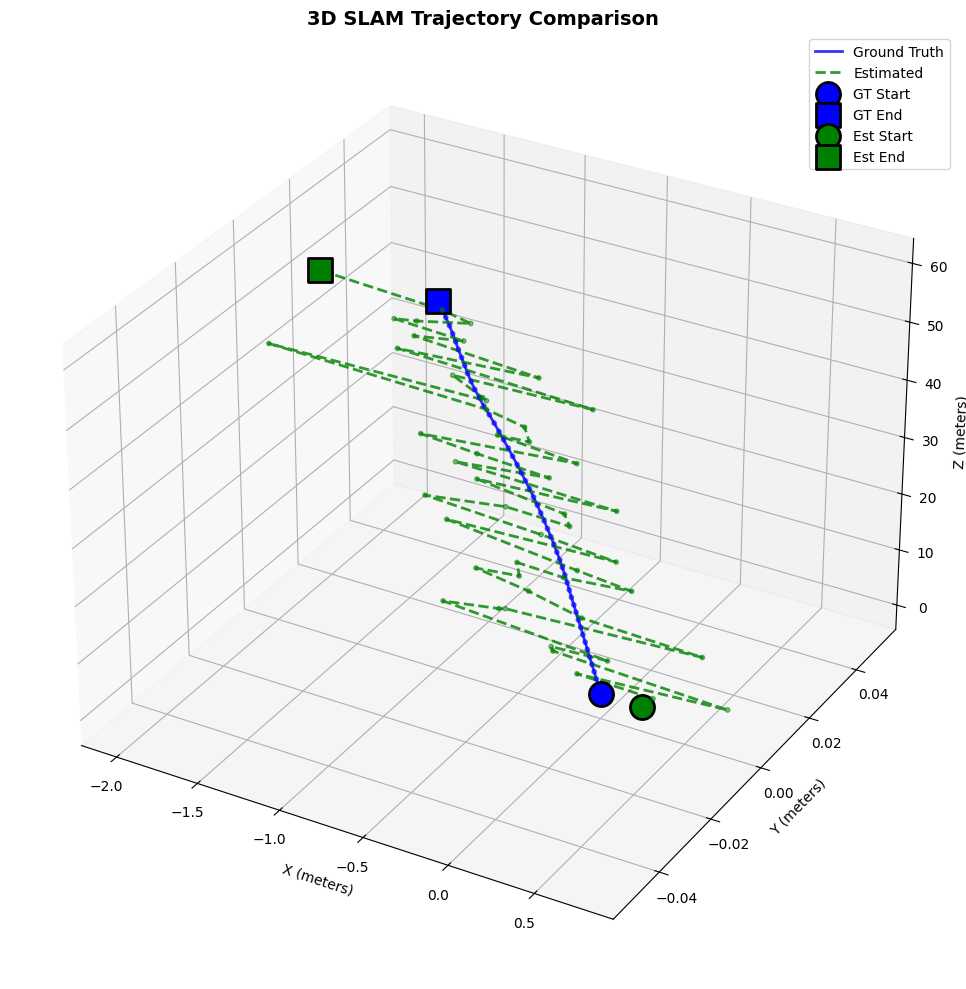

3D trajectory visualization displayed!


In [27]:
# 3D trajectory visualization (with Y dimension added)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create 3D path (X, Y as 0, Z)
gt_path_3d = np.column_stack([gt_path[:, 0], np.zeros(len(gt_path)), gt_path[:, 1]])
estimated_path_3d = np.column_stack([estimated_path[:, 0], np.zeros(len(estimated_path)), estimated_path[:, 1]])

# Plot GT trajectory
ax.plot(gt_path_3d[:, 0], gt_path_3d[:, 1], gt_path_3d[:, 2], 'b-', linewidth=2, label='Ground Truth', alpha=0.8)
ax.scatter(gt_path_3d[:, 0], gt_path_3d[:, 1], gt_path_3d[:, 2], c='blue', s=10, alpha=0.5)

# Plot estimated trajectory
ax.plot(estimated_path_3d[:, 0], estimated_path_3d[:, 1], estimated_path_3d[:, 2], 'g--', linewidth=2, label='Estimated', alpha=0.8)
ax.scatter(estimated_path_3d[:, 0], estimated_path_3d[:, 1], estimated_path_3d[:, 2], c='green', s=10, alpha=0.5)

# Mark start and end points
ax.scatter(*gt_path_3d[0], c='blue', s=300, marker='o', edgecolors='black', linewidth=2, label='GT Start', zorder=5)
ax.scatter(*gt_path_3d[-1], c='blue', s=300, marker='s', edgecolors='black', linewidth=2, label='GT End', zorder=5)

ax.scatter(*estimated_path_3d[0], c='green', s=300, marker='o', edgecolors='black', linewidth=2, label='Est Start', zorder=5)
ax.scatter(*estimated_path_3d[-1], c='green', s=300, marker='s', edgecolors='black', linewidth=2, label='Est End', zorder=5)

ax.set_xlabel('X (meters)', fontsize=10)
ax.set_ylabel('Y (meters)', fontsize=10)
ax.set_zlabel('Z (meters)', fontsize=10)
ax.set_title('3D SLAM Trajectory Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("3D trajectory visualization displayed!")